# Numerical Results

In [1]:
from utils.utils import reset_seed, LpNorm
from data.sampler import GaussianMixtureSampler, project_line_to_full_circle, DeepNetSampler
from models.score_matching import DenoisingScoreMatching
from models.dsm_cusum import OfflineScoreMatchingCUSUM, OnlineDenoisingScoreMatchingCUSUM
from models.other_baselines import CUSUM, SCUSUM, GMCUSUM
from utils.metric import WADDClass

import torch
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

## (1) Noise Injection Tradeoff Curve

In [16]:
reset_seed()

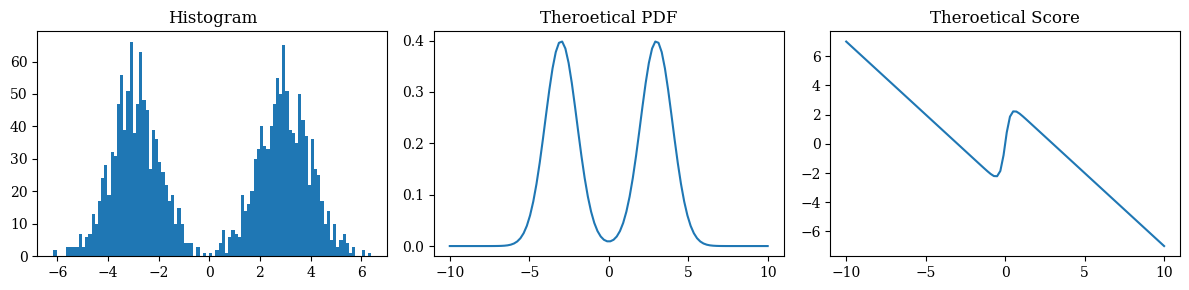

In [3]:
sampler_kwargs = {
    'mu0': np.array([[-1.], [1.]]) * 3,
    'mu1': np.array([[-1.], [1.]]) * 3,
    'noise_scale': 0.,
}
xx = np.linspace(-10., 10., 100).reshape(-1, 1)

sampler = GaussianMixtureSampler(**sampler_kwargs)
D = sampler.sample(1, 1000, 1000)[0, :, :]     # [ 2000, 1 ] 哪怕， iid sample from the Gaussian mixture distribution  

# visualization
fig, axes = plt.subplots(1, 3, figsize=[12, 3])

ax = axes[0]
ax.hist(D, bins = 100)
ax.set_title('Histogram')

ax = axes[1]
ax.plot(xx, sampler.pdf(xx))
ax.set_title('Theroetical PDF')

ax = axes[2]
ax.plot(xx, sampler.score(xx))
ax.set_title('Theroetical Score')

plt.tight_layout()
plt.show()

In [ ]:
sigmas = torch.linspace(0.01, 2, 20 * 10)
ntrial = 3
 
kwargs = {
    'data_dim':         1,
    'hidden_layers':    [ 128 ],
    'sigmas':           sigmas,
    'device':           'cuda'
}

fit_kwargs = {
    'data':         D,
    'num_epochs':   1000,
    'lr':           1e-4,
    'batch_size':   1024,
    'save_path':    'cache/trash',
    'patience':     1000,
}

# run
for i in range(ntrial):
    fit_kwargs['save_path'] = f'cache/tradeoff_exp/trial_{i}'
    model = DenoisingScoreMatching(**kwargs)
    # model.fit(**fit_kwargs)
    model.load(fit_kwargs['save_path'])

Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!


In [ ]:
ord = 1

est_err, pert_err, total_err     = [], [], []
p = sampler.pdf(xx).reshape(-1)
for j in range(ntrial):
    model = DenoisingScoreMatching(**kwargs)
    model.load(f'cache/tradeoff_exp/trial_{j}')         
    for i in range(len(sigmas)):
        score = model.score(torch.tensor(xx).float().to(model.device), i = i).reshape(-1)

        sampler_kwargs['noise_scale'] = sigmas[i]
        sampler = GaussianMixtureSampler(**sampler_kwargs)
        pert_score = sampler.score(xx).reshape(-1)

        sampler_kwargs['noise_scale'] = 0.
        sampler = GaussianMixtureSampler(**sampler_kwargs)
        real_score = sampler.score(xx).reshape(-1)

        est_err.append(LpNorm(score - pert_score, p, ord))
        pert_err.append(LpNorm(pert_score - real_score, p, ord))
        total_err.append(LpNorm(score - real_score, p, ord))

Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!


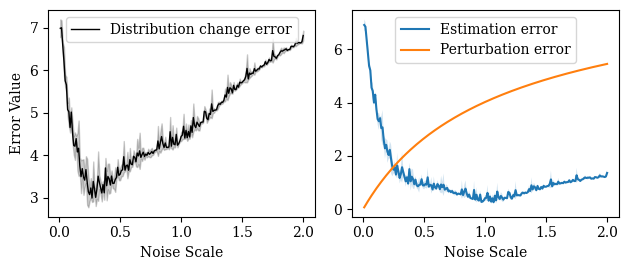

In [6]:
plt_scale = 0.8
fig, axes = plt.subplots(1, 2, figsize = [8 * plt_scale, 3.5 * plt_scale])

A, B, C = [], [], []
for i in range(ntrial):

    a = np.array(est_err)[i * len(sigmas): (i + 1) * len(sigmas)]
    b = np.array(pert_err)[i * len(sigmas): (i + 1) * len(sigmas)]
    c = (np.array(est_err) + np.array(pert_err))[i * len(sigmas): (i + 1) * len(sigmas)]

    A.append(a)
    B.append(b)
    C.append(c)

A = np.stack(A, -1) # [ len_sigmas, trials ] np, same below
B = np.stack(B, -1)
C = np.stack(C, -1)

ax = axes[0]
ax.plot(sigmas, C.mean(-1), label = r'Distribution change error', markersize = 4, lw = 1, color = 'black', ls = '-')
ax.fill_between(sigmas, C.mean(-1) - C.std(-1), C.mean(-1) + C.std(-1), alpha = 0.2, color = 'black')
ax.set_ylabel('Error Value')

ax = axes[1]
ax.plot(sigmas, A.mean(-1), ls = '-', alpha = 1, label = r'Estimation error')
ax.fill_between(sigmas, A.mean(-1) - A.std(-1), A.mean(-1) + A.std(-1), alpha = 0.2)

ax.plot(sigmas, B.mean(-1), ls = '-', alpha = 1, label = r'Perturbation error')
ax.fill_between(sigmas, B.mean(-1) - B.std(-1), B.mean(-1) + B.std(-1), alpha = 0.2)

for i in range(len(axes)):
    ax = axes[i]
    ax.legend(loc = 'upper center')
    ax.set_xlabel('Noise Scale')
plt.tight_layout()
plt.show()

plt.rcdefaults()

## (2) 2D Ring Gaussain Mixture Dataset  

In [2]:
reset_seed()

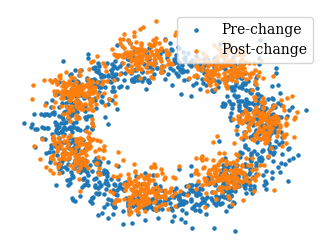

In [3]:
import matplotlib.pyplot as plt

data_dim =  2
n_points =  30 + 4
r =         3
tr_size =   1000

b = 5e-1
pre_dist = project_line_to_full_circle(a = 0, b = -b, r = r, n_points = n_points, upper=True)           # [ npoints, 2 ] np 
post_dist = project_line_to_full_circle(a = 0, b = b, r = r, n_points = n_points // 4, upper=False)     # [ npoints, 2 ] np
sampler = GaussianMixtureSampler(pre_dist, post_dist)

# training data
Dtr = sampler.sample(1, tr_size, tr_size)[0]
Dtr0, Dtr1 = Dtr[:tr_size], Dtr[tr_size:]

# plot
plt.figure(figsize=[4, 3])
plt.scatter(*Dtr0.T, s = 5, label = 'Pre-change')
plt.scatter(*Dtr1.T, s = 5, label = 'Post-change')
plt.axis(False)
plt.legend(loc='upper right')
plt.show()

In [4]:
# SMCUSUM
kwargs = {
    'data_dim':         data_dim,
    'hidden_layers':   [2048],         # 64
    'device':           'cuda'
}

fit_kwargs = {
    'lr':           1e-4,       # 2e-3
    'batch_size':   512,
    'num_epochs':   2000,       # 1000
    'save_path':    f'cache/2d_gm/smcusum',
    'patience':     2000
}

# NOTE: Hyvarinen (vanilla) SMCUSUM 
smcusum = OfflineScoreMatchingCUSUM(kwargs, type='hyvarinen')
# smcusum.fit(Dtr0, Dtr1, fit_kwargs)
smcusum.load(fit_kwargs['save_path'])

# NOTE: Denoising SMCUSUM
kwargs['sigmas'] = [1.]
fit_kwargs['save_path'] = f'cache/2d_gm/dsmcusum'
dsmcusum = OfflineScoreMatchingCUSUM(kwargs, type='denoising')
# dsmcusum.fit(Dtr0, Dtr1, fit_kwargs)
dsmcusum.load(fit_kwargs['save_path'])

Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!


In [5]:
# NOTE: Other baselines

# CUSUM
cusum = CUSUM(sampler)

# Score CUSUM
scusum = SCUSUM(sampler)

# Gaussian Mixture CUSUM (ncom from 1 to 5)
cusum_gms = []
for i in range(1, 6):
    cusum_gm = GMCUSUM(ncomp_pre=i, ncomp_post=i)
    cusum_gm.fit(Dtr0[np.newaxis, :, :], Dtr1[np.newaxis, :, :])
    cusum_gms.append(cusum_gm)

In [6]:
models = [ dsmcusum, smcusum, cusum, scusum, *cusum_gms ]
names   = [ 'DSM-CUSUM', 'SM-SCUSUM', 'Exact CUSUM', 'Exact SCUSUM', *[ f'GM({i})-CUSUM' if i != 1 else 'Gaussian CUSUM' for i in range(1, 6)] ]
markers = [ '*', 's', '^', 'o', *[ 'x' for i in range(1, 6)] ] 

In [7]:
Xs, Ys = [], []

wadd_kwargs = {
    'xxx':      200,
    'yyy':      1000,
    'n_iter':   100,
    'len_max':  300,
    'start':    2,
    'end':      4
}

wadd_class = WADDClass(sampler, **wadd_kwargs)
for i in range(len(models)):
    model = models[i]
    X, Y, Y_stds, Bs = wadd_class.WADD(model)
    Xs.append(X)
    Ys.append(Y)

ARLs: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


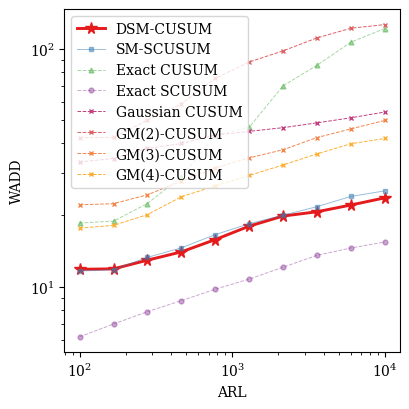

In [8]:
scale = 0.7
plt.figure(figsize=[6*scale, 6*scale])
for i in range(len(models)):

    if i == 8:
        continue

    X = Xs[i]
    Y = Ys[i]

    plt.plot(X, Y,
             marker = markers[i],
             label = names[i],
             markersize = 12*scale if i == 0 else 5*scale,
             lw = 3 * scale if i == 0 else 1 * scale,
             ls = '-' if i <= 1 else '--',
             alpha = 1. if i == 0 or i >= 4 else 0.5,
             color = plt.cm.Set1(i) if i < 4 else plt.cm.plasma(i * 30))

plt.xscale('log')
plt.yscale('log')
plt.ylabel('WADD')
plt.xlabel('ARL')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

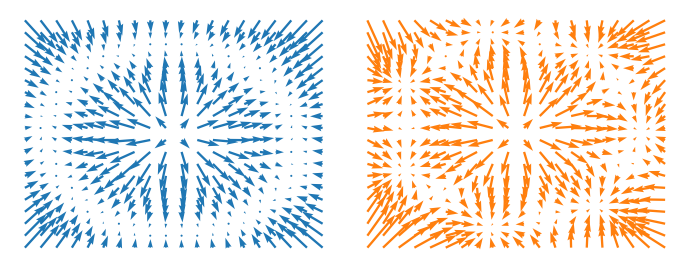

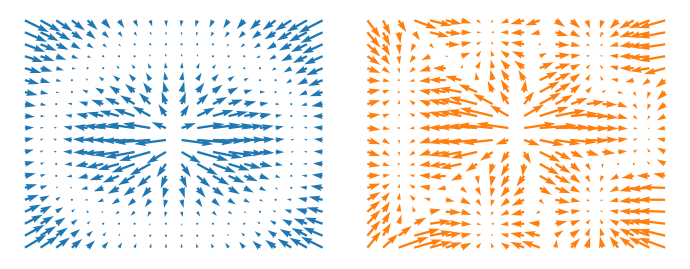

In [15]:
margin = 1.0
ngrids = 20
x, y = np.meshgrid(np.linspace(- 2 * r - margin, 2 * r + margin, ngrids),
                   np.linspace(- 2 * r - margin, 2 * r + margin, ngrids))
grids   = np.stack([x.ravel(), y.ravel()], -1)      # [ batch_size, 2] np

# estimated score
with torch.no_grad():
    score0 = dsmcusum.model1.score(torch.tensor(grids).float().to(dsmcusum.model1.device))  # [ batch_size, 2 ] np
    score1 = dsmcusum.model2.score(torch.tensor(grids).float().to(dsmcusum.model2.device))  # [ batch_size, 2 ] np

score0 = score0.reshape(ngrids, ngrids, 2)
score1 = score1.reshape(ngrids, ngrids, 2)

# theoretical score
score0_  = sampler.score(grids).reshape(ngrids, ngrids, 2)
score1_  = sampler.score(grids, dtype=1).reshape(ngrids, ngrids, 2)

# plot fig 1
scale = 1.4
fig, axes = plt.subplots(1, 2, figsize = [5 * scale, 2 * scale])

ax = axes[0]
ax.quiver(x, y, score0[:, :, 0], score0[:, :, 1], color = 'tab:blue', width = 0.007, scale = 20.0)

# plot fig 2
ax = axes[1]
ax.quiver(x, y, score1[:, :, 0], score1[:, :, 1], color = 'tab:orange', width = 0.007, scale = 20.0)

for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis(False)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize = [5 * scale, 2 * scale])
ax = plt

# plot fig 1 
ax = axes[0]
ax.quiver(x, y, score0_[:, :, 0], score0[:, :, 1], color = 'tab:blue', width = 0.007, scale = 40.0)

# plot fig 2
ax = axes[1]
ax.quiver(x, y, score1_[:, :, 0], score1[:, :, 1], color = 'tab:orange', width = 0.007, scale = 40.0)

for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis(False)
plt.tight_layout()
plt.show()

## (3) 10D Neural Network Data

In [6]:
reset_seed()

In [7]:
n0 = 1000
n1 = 1000

sampler_init_kwargs = {
    'latent_dim':   4,
    'data_dim':     10,
    'layers':       [ 256 ],
    'device':       'cpu'
}

sampler_fit_kwargs = {
    'nsample':      1000,
    'batch_size':   512,
    'lr':           1e-2,
    'nepoch':       100,
    'lam0':         1.,
    'lam1':         1.,
    'lam2':         0.,
    'save_path':    'cache/deep_net_sampler'
}

sampler = DeepNetSampler(**sampler_init_kwargs)
# sampler.fit(**sampler_fit_kwargs)
sampler.load(sampler_fit_kwargs['save_path'])

D = sampler.sample(1, n0, n1)[0]
Dtr0 = D[:n0]
Dtr1 = D[n0:]

Model loaded!


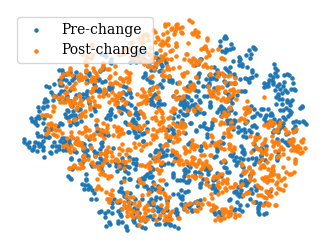

In [12]:
from sklearn.manifold import TSNE

Dtr0_2d = TSNE().fit_transform(Dtr0)
Dtr1_2d = TSNE().fit_transform(Dtr1)

plt.figure(figsize=[4, 3])
plt.scatter(*Dtr0_2d.T, s = 5, label = 'Pre-change')
plt.scatter(*Dtr1_2d.T, s = 5, label = 'Post-change')
plt.axis(False)
plt.legend()
plt.show()

In [8]:
# config
sigmas = [ 1. ]
 
kwargs = {
    'data_dim':         sampler_init_kwargs['data_dim'],
    'hidden_layers':    [ 512 ],
    'sigmas':           sigmas,
    'device':           'cuda'
}

fit_kwargs = {
    'num_epochs':   500,
    'lr':           1e-3,
    'batch_size':   512,
    'save_path':    f'cache/10d_nn/dsmcusum',
    'patience':     100,
}

# NOTE: DSMCUSUM
model = OfflineScoreMatchingCUSUM(kwargs, type = 'denoising')
# model.fit(Dtr0, Dtr1, fit_kwargs)
model.load(fit_kwargs['save_path'])

# NOTE: SMCUSUM
kwargs.pop('sigmas')
fit_kwargs['save_path'] = f'cache/10d_nn/smcusum'

model = OfflineScoreMatchingCUSUM(kwargs, type = 'hyvarinen')
# model.fit(Dtr0, Dtr1, fit_kwargs)
model.load(fit_kwargs['save_path'])

Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!
Found saved model and loaded!


In [9]:
# NOTE: Baseline: GMCUSUM
cusum_gms = []
for i in range(1, 6):
    cusum_gm = GMCUSUM(ncomp_pre=i, ncomp_post=i)
    cusum_gm.fit(Dtr0[np.newaxis, :, :], Dtr1[np.newaxis, :, :])
    cusum_gms.append(cusum_gm)

In [10]:
nmodel = 2 + len(cusum_gms)
wadd_kwargs = {
    'xxx':      200, # 200
    'yyy':      1000,
    'n_iter':   100,
    'len_max':  300,
    'start':    2,
    'end':      4
}

Xs, Ys = [], []
wadd_class = WADDClass(sampler, **wadd_kwargs)

for i in range(nmodel):

    if i == 0:
        kwargs['sigmas'] = sigmas
        model = OfflineScoreMatchingCUSUM(kwargs, type = 'denoising')
        model.load(f'cache/10d_nn/dsmcusum')
    elif i == 1:
        kwargs.pop('sigmas')
        model = OfflineScoreMatchingCUSUM(kwargs, type = 'hyvarinen')
        model.load(f'cache/10d_nn/smcusum')
    else:
        model = cusum_gms[i-2]

    X, Y, Y_stds, Bs = wadd_class.WADD(model)
    Xs.append(X)
    Ys.append(Y)

Found saved model and loaded!
Found saved model and loaded!


ARLs: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


Found saved model and loaded!
Found saved model and loaded!


ARLs: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


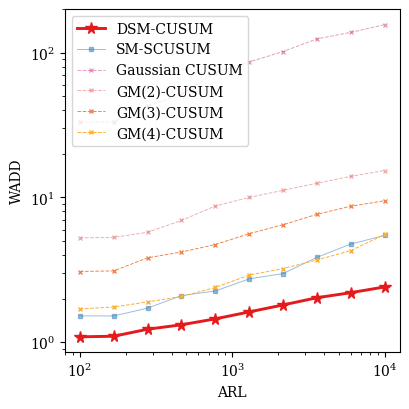

In [11]:
names   = [ 'DSM-CUSUM', 'SM-SCUSUM', *[ f'GM({i})-CUSUM' if i != 1 else 'Gaussian CUSUM' for i in range(1, 6)] ]
markers = [ '*', 's', *[ 'x' for i in range(1, 6)] ] 

scale = 0.7
plt.figure(figsize=[6*scale, 6*scale])
for i in range(nmodel):

    if i == 6:
        continue

    X = Xs[i]
    Y = Ys[i]

    plt.plot(X, Y,
             marker = markers[i],
             label = names[i],
             markersize = 12*scale if i == 0 else 5*scale,
             lw = 3 * scale if i == 0 else 1 * scale,
             ls = '-' if i <= 1 else '--',
             alpha = 1. if i == 0 or i >= 4 else 0.5,
             color = plt.cm.Set1(i) if i < 2 else plt.cm.plasma((i + 2) * 30))

plt.xscale('log')
plt.yscale('log')
plt.ylabel('WADD')
plt.xlabel('ARL')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()